# Task 3: Predictive Analysis

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

In [2]:
customer_profile = pd.read_csv('../dataset/customer_profile_kmeans.csv', sep='\t', index_col=0)
customer_profile

,I,Iu,Imax,E,Savg,R,F,M,cluster
CustomerID,,,,,,,,,
12347.0,7.668094,4.465908,6.516193,1.467671,6.396432,3.691376,5.017280,8.188192,high
12348.0,6.988413,2.197225,6.396930,0.974688,5.566358,4.332048,2.397895,6.664970,medium
12349.0,6.445720,4.276666,6.445720,1.387111,7.284512,2.949688,4.276666,7.284512,high
12350.0,5.278115,2.772589,5.278115,0.955511,5.684939,5.740114,2.772589,5.684939,medium
12352.0,6.137727,4.043051,4.828314,1.181226,5.351392,4.291828,4.248495,7.143151,medium
...,...,...,...,...,...,...,...,...,...
18280.0,3.806662,2.302585,3.806662,0.666002,5.196285,5.075799,2.302585,5.196285,low
18281.0,3.988984,1.945910,3.988984,0.663909,4.392224,1.410987,1.945910,4.392224,low
18282.0,4.584967,2.484907,4.248495,1.138492,4.480740,5.375741,2.484907,5.173887,low


In [3]:
customer_profile = customer_profile.to_numpy()

In [4]:
def plot_learning_curve(estimator, X, y, scorer='accuracy', cv=5, train_sizes=np.linspace(.1, 1.0, 5), 
                        shuffle=False, random_state=None):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, cv=cv,
                                                            scoring=scorer, n_jobs=-1, shuffle=shuffle,
                                                            random_state=random_state)

    mean_train_score = np.mean(train_scores, axis=1)
    std_train_score = np.std(train_scores, axis=1)
    mean_test_score = np.mean(test_scores, axis=1)
    std_test_score = np.std(test_scores, axis=1)

    plt.title(str(estimator.__class__.__name__) + ' learning curve')
    plt.xlabel('training set size')
    plt.ylabel('score')

    plt.plot(train_sizes, mean_train_score, label='train score', color='navy', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_train_score + std_train_score,
                     mean_train_score - std_train_score, color='navy', alpha=0.2)
    plt.plot(train_sizes, mean_test_score, label='cross-validation score', color='darkorange', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_test_score + std_test_score,
                     mean_test_score - std_test_score, color='darkorange', alpha=0.2)

    plt.legend().get_frame().set_facecolor('white')
    plt.show()
    
def highlight_equal(s, value, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] == value
    return ['background-color: lightyellow' if is_max.any() else '' for v in is_max]

## SVC

In [7]:
from sklearn.svm import SVC

In [11]:
X, y = customer_profile[:, :-1], customer_profile[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('svc', SVC())])

tuned_parameters = {'svc__kernel': ('linear', 'poly', 'rbf'),
                    'svc__C': (0.1, 1, 10, 100, 1000)}

grid = GridSearchCV(pipeline,
                    param_grid=tuned_parameters,
                    scoring='accuracy',
                    cv=5,  # 5 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit=True,  # refit the best model on the full development set
                    return_train_score=True,
                    verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished


In [12]:
df = pd.DataFrame(grid.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')
df.rename(columns={'mean_test_score': 'mean_val_score', 
                   'rank_test_score': 'rank_val_score'}, inplace=True)

df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()

params,mean_train_score,mean_val_score,rank_val_score
"{'svc__C': 100, 'svc__kernel': 'linear'}",0.999287,0.996830,1
"{'svc__C': 1000, 'svc__kernel': 'linear'}",0.999604,0.995562,2
"{'svc__C': 10, 'svc__kernel': 'linear'}",0.997860,0.995246,3
"{'svc__C': 1, 'svc__kernel': 'linear'}",0.996988,0.994295,4
"{'svc__C': 0.1, 'svc__kernel': 'linear'}",0.993183,0.992075,5
"{'svc__C': 10, 'svc__kernel': 'rbf'}",0.996512,0.988906,6
"{'svc__C': 1, 'svc__kernel': 'rbf'}",0.993818,0.987955,7
"{'svc__C': 1000, 'svc__kernel': 'rbf'}",1.000000,0.987636,8
"{'svc__C': 100, 'svc__kernel': 'poly'}",0.997781,0.987635,9
"{'svc__C': 100, 'svc__kernel': 'rbf'}",0.999366,0.987002,10


In [13]:
accuracy_score(grid.best_estimator_.predict(X_test), y_test)

0.997148288973384

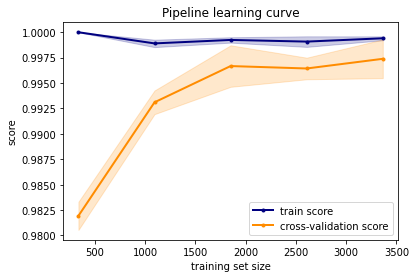

In [14]:
plot_learning_curve(grid.best_estimator_, X, y)

## Naive Bayes

## Random Forest

## Gradient Boosting

## Decision Tree

## K-Nearest Neighbors

## Logistic Regression